In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Reloading the module
import importlib

import OrthogonalPolynomials
importlib.reload(OrthogonalPolynomials)
from OrthogonalPolynomials import *

import GeneralFunctionality
importlib.reload(GeneralFunctionality)
from GeneralFunctionality import *

In [2]:
# Auxiliary constants
def alpha(n):
    return 1/np.sqrt(4*n+6)

def mu(n):
    return -2/(2*n+5)

def gamma(n):
    return -2/(2*n+1)

def beta(n):
    return 2/(2*n+1) + 2/(2*n+5)

In [3]:
# Constructing the tri-diagonal matrices for the even and odd coefficients
def EndIndexEven(N):
    # Finding the last index for the even terms
    q = N%2
    return (N-2-q)//2

def EndIndexOdd(N):
    # Finding the last index for the odd terms
    q = N%2
    return (N-4+q)//2

def MatrixTriDiag(N, label):
    # Constructing the tri-diagonal matrix for the even coefficients
    # Return the three diagonals, not the matrix itself
    
    # Finding the end index
    if label=='even':
        ind_end = EndIndexEven(N)
        p = 0
    else:
        ind_end = EndIndexOdd(N)
        p = 1
    
    # Initialize
    l = np.zeros(ind_end+1)
    d = np.zeros(ind_end+1)
    u = np.zeros(ind_end+1)
   
    
    for n in range(0, ind_end+1):
        d[n] = alpha(2*n+p) * alpha(2*n+p) * beta(2*n+p)
    
    for n in range(1, ind_end+1):
        l[n] = alpha(2*n+p) * alpha(2*n-2+p) * gamma(2*n+p)
        
    for n in range(0, ind_end):
        u[n] = alpha(2*n+p) * alpha(2*n+2+p) * mu(2*n+p)
        
    return d, l, u

In [4]:
def MatrixM(N):
    # Constructing the matrix M directly
    # Both the row and the column indices range from 0 to N-2
    M = np.zeros((N-1, N-1))
    for n in range(N-1): # n=0,1,...,N-2
        for k in range(N-1): # k=0,1,...,N-2
            M[n,k] = alpha(n)*alpha(k)*(beta(n)*delta(n,k) 
                                       +mu(n)*delta(n,k-2) 
                                       +gamma(n)*delta(n,k+2))
    return M

In [5]:
def MatrixH(N):
    # Constructing the matrix H directly
    # H_{mk} = (\phi_m, K_k)
    
    H = np.zeros((N-1, N+1))
    for m in range(N-1): # m=0,1,...,N-2
        for k in range(N+1): # k=0,1,...,N
            H[m,k] = alpha(m) * (- delta(k,m) * gamma(m) 
                                 + delta(k,m+2) * mu(m))
    return H

In [6]:
def InitCond(u0, N):
    # Finding initial coefficients
    
    # Initial legendre coefficients
    coeff_legendre = LegendreCoefficients(u0, N)
    # Transformation matrix H
    H = MatrixH(N)
    # RHS for solve the initial coefficients
    rhs = np.dot(H, coeff_legendre)
    # Extracting even and odd terms
    rhs_even = rhs[0::2]
    rhs_odd = rhs[1::2]
    # Solving the even and odd coefficients
    d, l, u = MatrixTriDiag(N, 'even')
    coeff_even = TridiagonalSolver(len(d)-1, d, l, u, rhs_even)
    d, l, u = MatrixTriDiag(N, 'odd')
    coeff_odd = TridiagonalSolver(len(d)-1, d, l, u, rhs_odd)
    
    return coeff_even, coeff_odd

def CombineEvenOddCoeff(coeff_even, coeff_odd):
    # Combine the even and the odd coefficients to get all coefficients
    coeff = np.zeros(len(coeff_even)+len(coeff_odd))
    coeff[0::2] = coeff_even
    coeff[1::2] = coeff_odd
    return coeff

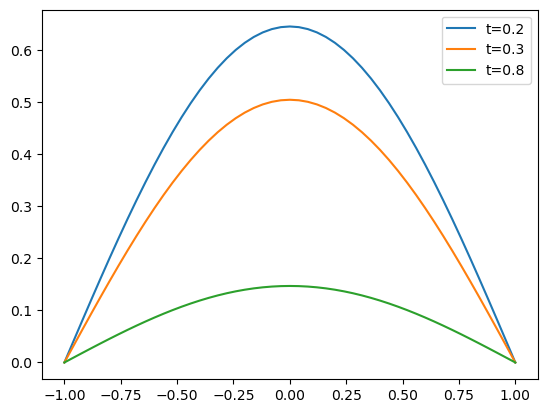

In [9]:
# Initial conditions
def init_func(x):
    return 1-x**2

N = 20
coeff_even, coeff_odd = InitCond(init_func, N)

# Implicit trapezoidal rule
dt = 1e-2
t_end = 1


# Time instants to evaluate the solution
t_eval_list = [0.2, 0.3, 0.8]
# Create a list to store the coefficients at t_eval
coeff_even_list = []
coeff_odd_list = []

# Creating the matrices for the even coefficients
d_even, l_even, u_even = MatrixTriDiag(N, 'even')
d_right_even = d_even - 0.5*dt
d_left_even = d_even + 0.5*dt
# Creating the matrices for the odd coefficients
d_odd, l_odd, u_odd = MatrixTriDiag(N, 'odd')
d_right_odd = d_odd - 0.5*dt
d_left_odd = d_odd + 0.5*dt


ind_t_eval = 0
t_eval = t_eval_list[ind_t_eval]

t = 0
while t<=t_end:
    # If t is close to t_eval, store the coefficients
    if t<=t_eval and t+dt>t_eval:
        coeff_even_list.append(coeff_even)
        coeff_odd_list.append(coeff_odd)
        ind_t_eval += 1
        # If not reached the last t_eval, set t_eval to the next element in t_eval_list
        if ind_t_eval<=len(t_eval_list)-1:
            t_eval = t_eval_list[ind_t_eval]
    
    # Solving the even coefficients
    rhs_even = TridiagonalMultiplication(d_right_even,l_even,u_even,coeff_even)
    coeff_even = TridiagonalSolver(len(d_even)-1, d_left_even, l_even, u_even, rhs_even)
    # Solving the odd coefficients
    rhs_odd = TridiagonalMultiplication(d_right_odd, l_odd, u_odd, coeff_odd)
    coeff_odd = TridiagonalSolver(len(d_odd)-1, d_left_odd, l_odd, u_odd, rhs_odd)
    
    t += dt


    
# Evaluation of the solution
fig = plt.figure()
ax = fig.add_subplot(111)

x = np.linspace(-1, 1, 51)

for t_eval, coeff_even, coeff_odd in zip(t_eval_list, coeff_even_list, 
                                         coeff_odd_list):
    u = np.zeros(x.shape)
    coeff = CombineEvenOddCoeff(coeff_even, coeff_odd)
    for i in range(len(x)):
        u[i] = LegendreGalerkinTruncation(x[i], coeff)
    
    ax.plot(x, u, label='t={}'.format(t_eval))
    
ax.legend()